# Libraries

In [2]:
%matplotlib inline
from collections.abc import Iterable, Sequence
from collections import Counter
from collections import defaultdict
import copy
import enum
import time
from datetime import datetime
import calendar
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
import re
import nltk

import custom_transformers 
import custom_preprocessing
import custom_loaders

from sklearn.experimental import enable_halving_search_cv

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline, FeatureUnion

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline

import seaborn

# Load data

In [11]:
#############
# Execution #
#############

training_features_dataframe, training_targets_dataframe = custom_loaders.get_dataframes_from_csv("data/train_data.csv",
                                                                                                 "data/train_target.csv")
training_comments : list[str] = list(training_features_dataframe.body)
training_targets : list[int] = custom_loaders.get_targets_from_dataframe(training_features_dataframe,
                                                                         training_targets_dataframe)

print(training_comments[:3])
print(training_targets[:3])

["I don't think we'd get nearly as much fanfiction and pictures shipping Ban-Ban and Lyro. Just saying.", "Thanks. I made it up, that's how I got over my first heart break. ", "Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys](http://i.imgur.com/c3YKPdI.jpg)\n\nMaybe I'm just a bad player... But every time I faced one on my first playthrough, all my pawns ended up getting to 0 HP at least once and I could barely get an attack in once it started berserking."]
[0, 1, 0]


# Group by author

In [12]:
#############
# Execution #
#############

training_features_dataframe_groupby_author = custom_loaders.group_dataframe_by_author(training_features_dataframe)

training_comments_groupby_author : list[str] = list(training_features_dataframe_groupby_author.body)
training_targets_groupby_author : list[int] = custom_loaders.get_targets_from_dataframe(training_features_dataframe_groupby_author,
                                                                                        training_targets_dataframe)

print(training_features_dataframe_groupby_author.head())
print(training_comments_groupby_author[:1])
print(training_targets_groupby_author[:5])

           author                                          subreddit  \
0          -Jared   AskReddit tall pics StarWars AskReddit AskReddit   
1         -Peeter                                             gainit   
2        -evasian  MouseReview MechanicalKeyboards jailbreak jail...   
3         -rubiks  AskWomen AskWomen AskWomen AskWomen AskWomen A...   
4  -true_neutral-                    mildlyinteresting todayilearned   

                                                body  \
0  Neil Diamond - Sweet Caroline +1 on the chirop...   
1                         Just read the FAQ, really.   
2  I just received my Deathadder Black Edition ye...   
3  AlunaGeorge - Best Be Believing\nArctic Monkey...   
4  &gt; Urban Ears Metis\n\nYMMV. I have had thre...   

                                         created_utc  
0  1390189315.0,1390189970.0,1390492589.0,1390496...  
1                                       1389962703.0  
2  1388678755.0,1388688144.0,1389891805.0,1389892...  
3  1389194

# Generate Part-Of-Speech data

We implement a custom vectorizer for Part-Of-Speech data.  
A survey of relevant literature points to personal pronouns, indefinite articles and other Parts-of-Speech as fairly accurate predictors of the author's gender.

In [13]:
#############
# Execution #
#############

pos_vectorizer = custom_transformers.PosTagVectorizer()
print(pos_vectorizer.fit_transform(training_features_dataframe_groupby_author[1:10]))
print(pos_vectorizer.get_feature_names_out())

  (0, 2)	1.0
  (0, 10)	1.0
  (0, 15)	2.0
  (0, 22)	1.0
  (1, 0)	14.0
  (1, 2)	65.0
  (1, 3)	4.0
  (1, 5)	78.0
  (1, 6)	49.0
  (1, 7)	5.0
  (1, 8)	1.0
  (1, 9)	10.0
  (1, 10)	116.0
  (1, 11)	21.0
  (1, 13)	30.0
  (1, 14)	8.0
  (1, 15)	33.0
  (1, 16)	1.0
  (1, 18)	3.0
  (1, 20)	20.0
  (1, 21)	1.0
  (1, 22)	37.0
  (1, 23)	13.0
  (1, 24)	15.0
  (1, 25)	11.0
  :	:
  (8, 5)	267.0
  (8, 6)	187.0
  (8, 7)	12.0
  (8, 8)	7.0
  (8, 9)	54.0
  (8, 10)	428.0
  (8, 11)	100.0
  (8, 12)	2.0
  (8, 13)	117.0
  (8, 14)	47.0
  (8, 15)	164.0
  (8, 16)	10.0
  (8, 17)	3.0
  (8, 18)	15.0
  (8, 20)	81.0
  (8, 22)	156.0
  (8, 23)	69.0
  (8, 24)	47.0
  (8, 25)	57.0
  (8, 26)	79.0
  (8, 27)	40.0
  (8, 28)	5.0
  (8, 29)	22.0
  (8, 30)	1.0
  (8, 31)	17.0
['CC' 'CD' 'DT' 'EX' 'FW' 'IN' 'JJ' 'JJR' 'JJS' 'MD' 'NN' 'NNS' 'PDT'
 'PRP' 'PRP$' 'RB' 'RBR' 'RBS' 'RP' 'SYM' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN'
 'VBP' 'VBZ' 'WDT' 'WP' 'WP$' 'WRB']


# Generate subreddit data

In [14]:
#############
# Execution #
#############

subreddit_vectorizer = custom_transformers.SubredditVectorizer()
print(subreddit_vectorizer.fit_transform(training_features_dataframe_groupby_author))
print(subreddit_vectorizer.get_feature_names_out())

  (0, 139)	3.0
  (0, 1313)	1.0
  (0, 2844)	1.0
  (0, 3220)	1.0
  (1, 2243)	1.0
  (2, 139)	1.0
  (2, 916)	1.0
  (2, 958)	1.0
  (2, 2446)	7.0
  (3, 132)	1.0
  (3, 148)	8.0
  (4, 2631)	1.0
  (4, 3274)	1.0
  (5, 2407)	3.0
  (5, 3270)	1.0
  (6, 2683)	1.0
  (7, 139)	1.0
  (8, 728)	1.0
  (8, 1745)	2.0
  (8, 3304)	2.0
  (9, 52)	1.0
  (9, 139)	12.0
  (9, 193)	1.0
  (9, 728)	2.0
  (9, 1521)	5.0
  :	:
  (4992, 1468)	3.0
  (4992, 1473)	5.0
  (4992, 2724)	5.0
  (4992, 3161)	6.0
  (4992, 3292)	1.0
  (4992, 3342)	4.0
  (4993, 1193)	2.0
  (4993, 1867)	1.0
  (4994, 2506)	3.0
  (4995, 1054)	1.0
  (4996, 52)	4.0
  (4996, 345)	1.0
  (4996, 904)	4.0
  (4996, 1004)	20.0
  (4996, 1420)	1.0
  (4996, 1697)	1.0
  (4996, 2171)	2.0
  (4996, 2204)	2.0
  (4996, 2284)	1.0
  (4996, 2567)	1.0
  (4996, 2844)	1.0
  (4997, 3368)	4.0
  (4998, 1114)	3.0
  (4998, 2801)	1.0
  (4999, 139)	2.0
['1022' '1200isplenty' '1911' ... 'zen' 'zombies' 'zyzz']


# Generate timestamp data

We create a custom timestamp vectorizer that turns the list of epoch times in the `created_utc` feature (grouped by author) in a matrix of counts binned by weekday and hour.  
By plotting user activity we notice significant outliers: the honorable mention goes to the user ___u/morbiusgreen___, still active on various subs and posting up to 500 comments in one hour.  
We will later implement an outlier removal routine to get rid of the graphomaniacs (and other outliers) tainting our dataset.

In [15]:
#############
# Execution #
#############

epoch_vectorizer = custom_transformers.EpochVectorizer()
print(epoch_vectorizer.fit_transform(training_features_dataframe_groupby_author))
print(epoch_vectorizer.get_feature_names_out())

  (0, 3)	2.0
  (0, 87)	1.0
  (0, 89)	1.0
  (0, 92)	1.0
  (0, 93)	1.0
  (1, 108)	1.0
  (2, 39)	1.0
  (2, 61)	1.0
  (2, 63)	2.0
  (2, 66)	1.0
  (2, 88)	1.0
  (2, 89)	2.0
  (2, 90)	1.0
  (2, 93)	1.0
  (3, 63)	1.0
  (3, 86)	3.0
  (3, 98)	2.0
  (3, 109)	1.0
  (3, 111)	1.0
  (3, 148)	1.0
  (4, 72)	1.0
  (4, 100)	1.0
  (5, 4)	1.0
  (5, 22)	2.0
  (5, 26)	1.0
  :	:
  (4996, 66)	1.0
  (4996, 67)	2.0
  (4996, 68)	1.0
  (4996, 70)	4.0
  (4996, 88)	3.0
  (4996, 89)	3.0
  (4996, 90)	1.0
  (4996, 91)	1.0
  (4996, 98)	3.0
  (4996, 103)	1.0
  (4996, 105)	1.0
  (4996, 111)	2.0
  (4996, 114)	1.0
  (4996, 117)	4.0
  (4996, 119)	1.0
  (4996, 121)	1.0
  (4996, 136)	1.0
  (4996, 164)	1.0
  (4997, 20)	2.0
  (4997, 23)	2.0
  (4998, 26)	1.0
  (4998, 27)	1.0
  (4998, 28)	1.0
  (4998, 119)	1.0
  (4999, 82)	2.0
['000_MONDAY_00' '001_MONDAY_01' '002_MONDAY_02' '003_MONDAY_03'
 '004_MONDAY_04' '005_MONDAY_05' '006_MONDAY_06' '007_MONDAY_07'
 '008_MONDAY_08' '009_MONDAY_09' '010_MONDAY_10' '011_MONDAY_11'
 '012_MONDA

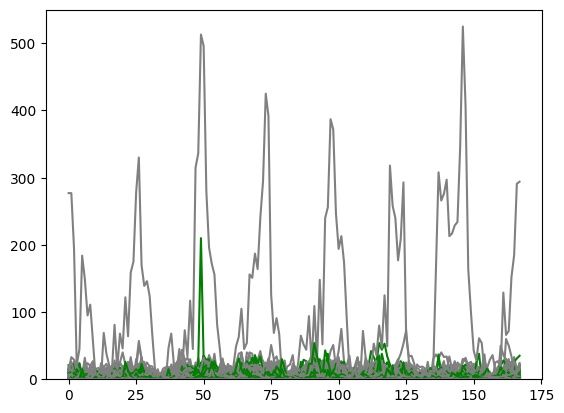

In [16]:
#########
# Plots #
#########
colormap = np.array(['gray', 'g'])
colors = colormap[training_targets_groupby_author]

lines = plt.plot(np.array(range(168)).T,epoch_vectorizer.transform(training_features_dataframe_groupby_author).toarray().T)
ax = plt.gca()
ax.set_ylim([0, 550])

for idx, color in enumerate(colors):
    lines[idx].set_color(color)
plt.show()

# Generate username data

We create a custom username vectorizer, counting single-character occurrence and total length of the username.

In [17]:
#############
# Execution #
#############

username_vectorizer = custom_transformers.UsernameVectorizer()
print(username_vectorizer.fit_transform(training_features_dataframe_groupby_author).A)
print(username_vectorizer.get_feature_names_out())


[[1 0 0 ... 0 0 6]
 [1 0 0 ... 0 0 7]
 [1 0 0 ... 0 0 8]
 ...
 [0 0 0 ... 0 2 7]
 [0 0 0 ... 0 2 4]
 [0 0 0 ... 0 2 7]]
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'length']


# Generate TF-IDF comment data

We wrap the built-in `TfIdfVectorizer` in a `BodyVectorizer` class (see `custom_transformers`). We enrich the built-in vectorizer with lemmatization via `nltk.stem.WordNetLemmatizer`.

# Data Clean-up

## Outlier Rejection

We reject outliers based on anomalous comments/hour. We leverage the `sklearn.ensemble.IsolationForest` classifier, which is a tree-based anomaly detection algorithm.  
Even if it's feasible to manipulate both features and targets in-pipeline via `imblearn.pipeline.Pipeline` after some experiments we decide integrating outlier detection in the pipeline is not necessary.

## Textual Data Cleaning

We process letters-only words of three or more characters by lemmatizing them via `nltk.stem.WordNetLemmatizer` embedded in a custom tokenizer passed to `TfidfVectorizer` (see `custom_transformers.tokenize`). We use the standard english stop-words even if they include personal pronouns (good predictors of gender in writing) as Parts-Of-Speech tags are counted separately (only on letters-only words as well).

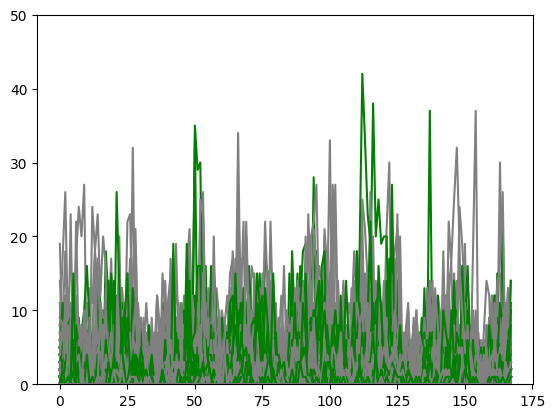

# of valid samples: 4751


In [18]:
#########
# Plots #
#########
epoch_vectorizer = custom_transformers.EpochVectorizer()

X_outliers = epoch_vectorizer.fit_transform(training_features_dataframe_groupby_author)
y_outliers = training_targets_groupby_author

reject_sampler = FunctionSampler(func=custom_preprocessing.outlier_rejection)
X_inliers, y_inliers = reject_sampler.fit_resample(X_outliers, y_outliers)

colormap = np.array(['gray', 'g'])
colors = colormap[y_inliers]

lines = plt.plot(np.array(range(168)).T,X_inliers.toarray().T)
ax = plt.gca()
ax.set_ylim([0, 50])

for idx, color in enumerate(colors):
    lines[idx].set_color(color)
plt.show()
print(f'# of valid samples: {len(y_inliers)}')

# Latent Semantic Analysis

We implement LSA in our pipeline using the built-ins `TruncatedSVD` and `LatentDirichletAllocation`.

# Training Pipeline

We compose a pipeline that combines all our vectorizers via `FeatureUnion`, scales the data via `MaxAbsScaler`, performs latent semantic analysis via `TruncatedSVD`, and fits it via different estimators `LogisticRegression` and `SVC`

In [3]:
#####################
# Training Pipeline #
#####################
def get_training_pipeline():
    features = FeatureUnion([("vct", custom_transformers.BodyVectorizer(ngram_range=(1,2), sublinear_tf=True)),
                             ("usr", custom_transformers.UsernameVectorizer(ngram_range=(1,3))),
                             ("sub", custom_transformers.SubredditVectorizer())])
    
    features_dict = dict([("vct", custom_transformers.BodyVectorizer()),
                          ("pos", custom_transformers.PosTagVectorizer()),
                          ("utc", custom_transformers.EpochVectorizer()),
                          ("usr", custom_transformers.UsernameVectorizer(ngram_range=(1,3))),
                          ("sub", custom_transformers.SubredditVectorizer())])
                                  


    training_pipeline = Pipeline([("features", features),
                                  ("scaler", MaxAbsScaler()),
                                  ("lsa", TruncatedSVD(n_components=100, random_state=0)),
                                  ("classifier", SVC(random_state=0))],
                                 memory='pipeline_cache', 
                                 verbose=True)
    return training_pipeline

In [4]:
#############
# Model Fit #
#############

#final_features, final_targets = custom_loaders.get_training_data()
training_pipeline = get_training_pipeline()
# training_pipeline.fit(final_features[1:100], final_targets[1:100])
# print(training_pipeline.score(final_features, final_targets))
# print(cross_val_score(training_pipeline, final_features, final_targets, n_jobs=-1, verbose=100, scoring='roc_auc'))

In [5]:
###################
# In-Sample Score #
###################

selection_pipeline.score(final_features, final_targets)

0.6842810114414141

# Model Selection

We do a `GridSearchCV` with a `StratifiedShuffleSplit` for each feature group on itself (usernames, subreddits, etc.) and all together.  
Comment times are useful to identify outliers but don't perform well as gender predictors (at least with our pipeline, maybe with a rolling average/different classifier they would perform better). PoS tags are very expensive for not much benefit.  
While visualizing features we notice we have mixed languages in our bunch, and they get represented as segregated topics. 

In [ ]:
###################
# Model Selection #
###################

n_components = [100, 200, 400]
ks = [100, 200, 400]
max_dfs = [1.0, 0.7]
min_dfs = [1, 0.3]
token_patterns = [r"(?u)\b\w\w+\b"] # without lemmatization
tokenizers = [custom_transformers.tokenize] # with lemmatization
ngrams_tfidf = [(1, 1), (1, 2)]
gammas = ['scale']
ngrams_username = [(1, 1), (3, 3)]
cs = [0.01, 0.1, 1, 10]
classifiers = [LogisticRegression(max_iter=10000, random_state=0), SVC(random_state=0)]
reductors = [LatentDirichletAllocation(random_state=0), TruncatedSVD(random_state=0), SelectKBest()]


param_grid = [{'features__vct__max_df' : max_dfs,
               'features__vct__min_df' : min_dfs,
               'features__vct__token_pattern' : token_patterns,
               'lsa__n_components' : n_components, 
               'classifier__C' : cs, 
               'classifier__gamma' : gammas}, 
              {'features__vct__max_df' : max_dfs,
               'features__vct__min_df' : min_dfs,
               'features__vct__tokenizer' : tokenizers,
               'lsa__n_components' : n_components, 
               'classifier__C' : cs, 
               'classifier__gamma' : gammas}]

demo_param_grid = [{'features__vct__max_df' : [1.0],
                    'features__vct__min_df' : [1],
                    'features__vct__tokenizer' : tokenizers,
                    'lsa__n_components' : [100, 200], 
                    'classifier__C' : [0.1, 1, 10], 
                    'classifier__gamma' : ['scale']}]

single_feature_param_grid = [{'lsa__n_components' : [200], 
                              'classifier__C' : [1], 
                              'classifier__gamma' : ['scale']}]

selection_pipeline = GridSearchCV(training_pipeline, 
                                  param_grid=single_feature_param_grid, 
                                  scoring='roc_auc', 
                                  n_jobs=-1,
                                  verbose=100,
                                  cv=StratifiedShuffleSplit(n_splits=5, train_size=0.80))

selection_pipeline.fit(final_features, final_targets)

print(selection_pipeline.best_params_)
print(selection_pipeline.best_score_)
pd.DataFrame.from_dict(selection_pipeline.cv_results_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


# Feature Visualization

In [5]:
#########################
# Feature Visualization #
#########################

pipeline_to_visualize = selection_pipeline.best_estimator_

feature_names = [*pipeline_to_visualize.steps[0][1].transformer_list[0][1].vectorizer.get_feature_names_out(),
                 *pipeline_to_visualize.steps[0][1].transformer_list[1][1].vectorizer.get_feature_names_out(),
                 *pipeline_to_visualize.steps[0][1].transformer_list[2][1].vectorizer.get_feature_names_out(),
                 *pipeline_to_visualize.steps[0][1].transformer_list[3][1].vectorizer.get_feature_names_out(),
                 'USERNAME_LENGTH',
                 *pipeline_to_visualize.steps[0][1].transformer_list[4][1].vectorizer.get_feature_names_out()]

for idx, feature in enumerate(list(pipeline_to_visualize.steps[2][1].components_)):
    row = f'Component {idx:03}: '
    for idf, component in enumerate(feature):
        if (idf < len(feature_names) and component > 0.035):
            row = row + f'{feature_names[idf]} '  
    print(row)

Component 000: about after all also and are as at be because being but can could do don down first for from get go good had has have he how http if in into is it just know like ll me most my not now of on one only or other out over people pretty re really so some something still sure than that the their them then there they things think this to up ve was well were what when which will with would you your CC DT IN JJ MD NN PRP RB TO VB VBG VBP VBZ a c d e g h i l n o r s t USERNAME_LENGTH 
Component 001: about and are as be because but can do don for have if in it most not of on or people that the their to which with you 
Component 002: 01040m 125cc 14hs 15pesos 1v3 370z 3some 450lbs 4800 5hours 6a00d8353fdf2669e20120a64c4ef5970b 9km abajo abuela aburrido acepte actresse actuales acá adaptar adaptarme ademas adentro admitir adrenalina advange afectiva afippppppp agarrar agradecerles aguante alcanzaba alemania algo algunos allá alquilar alquileres ambas ambientes amenaza amenazo amputado

# Evaluate on Test Set